In [8]:
'''
grand average plots based on pile_all mat files generated by compare_constructs_GCaMP96uf

this cell generates the pkls for the next cell to analyze. if no new data was added, do not run

'''

from scipy.io import loadmat
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

ap_idx = 0 # 0: 1AP, 1: 3AP, 2:10AP, 3:160AP

html_write_dir = r'D:\site\ilyakolb.github.io\interactive_norm_plots.html'
pdf_dir = r"D:\ufgcamp_paper_data\culture-screen-figs/norm_plots.pdf"
plot_mat = loadmat(r'data/unnormPlots_singleWells_struct.mat')

subplot_titles = ['peak dF/F', 'SNR', 'half-rise time (ms)', 'full rise time (ms)', 'half-decay time (ms)']
df_cols = subplot_titles.copy()
df_cols.insert(0,'construct')

# labels and order of legend
hits_label = ['jGCaMP8f', 'jGCaMP8m', 'jGCaMP8s', 'GCaMP6s', 'jGCaMP7f', 'jGCaMP7s', 'XCaMP-Gf']

# magnify the kinetics of the following hits
magnify_hits_label = ['jGCaMP8f', 'jGCaMP8m', 'jGCaMP8s']

all_data = plot_mat['unnormPlots_singleWells_struct'][0]

all_constructs = [c[0] for c in all_data['construct']]

# create dataframe
df = pd.DataFrame(columns=df_cols)

for construct_idx in range(len(all_constructs)):
    n_wells = len(all_data[construct_idx][1][ap_idx])
    
    dff = all_data[construct_idx][1][ap_idx]
    snr = all_data[construct_idx][2][ap_idx]
    
    # get kinetics, convert to milliseconds
    halfrise = all_data[construct_idx][3][ap_idx]*1000
    fullrise = all_data[construct_idx][4][ap_idx]*1000
    halfdecay = all_data[construct_idx][5][ap_idx]*1000
    
    current_construct = [all_data[construct_idx][0][0]] * n_wells
    df_construct = pd.DataFrame(np.array([current_construct, dff, snr, halfrise, fullrise, halfdecay]).T, columns=df_cols)
    df = df.append(df_construct)

# cast data columns as floats
castdict = {x: 'float' for x in subplot_titles}
df = df.astype(castdict)
print('Saving...', end='')
df.to_pickle('data/grand-avg-data_{}.pkl'.format(ap_idx))
print('Done')

NameError: name 'snr' is not defined

============1AP============


<ipython-input-1-1594c8c4206d>:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()
<ipython-input-1-1594c8c4206d>:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()
<ipython-input-1-1594c8c4206d>:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


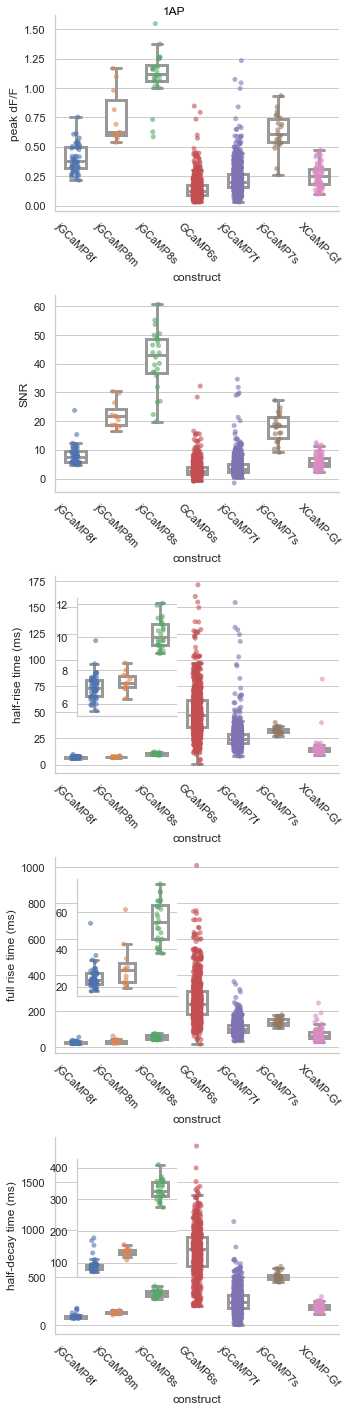

,peak dF/F,SNR,half-rise time (ms),full rise time (ms),half-decay time (ms)
construct,,,,,
GCaMP6f,0.11+/-0.073,1.32+/-1.553,31.0+/-17.318,110.11+/-52.248,300.93+/-72.671
GCaMP6s,0.14+/-0.086,3.08+/-2.807,50.83+/-22.589,258.02+/-118.551,763.94+/-259.231
XCaMP-G,0.25+/-0.101,7.17+/-3.109,19.79+/-5.949,99.22+/-37.26,254.35+/-65.848
XCaMP-Gf,0.25+/-0.095,5.96+/-2.432,15.6+/-8.951,71.08+/-38.202,194.09+/-34.028
XCaMP-Gf0,0.2+/-0.082,4.71+/-2.215,16.91+/-15.307,83.05+/-46.503,219.84+/-62.093
jGCaMP7b,0.56+/-0.13,22.94+/-5.799,43.14+/-3.829,171.17+/-24.239,412.9+/-31.105
jGCaMP7c,0.24+/-0.087,7.19+/-2.639,30.2+/-7.006,165.75+/-34.878,432.38+/-135.227
jGCaMP7f,0.23+/-0.117,4.2+/-3.175,26.58+/-11.717,106.78+/-36.878,254.31+/-121.522
jGCaMP7s,0.62+/-0.159,17.74+/-4.899,32.44+/-3.126,139.78+/-19.601,515.62+/-44.188


============3AP============


<ipython-input-1-1594c8c4206d>:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()
<ipython-input-1-1594c8c4206d>:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()
<ipython-input-1-1594c8c4206d>:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


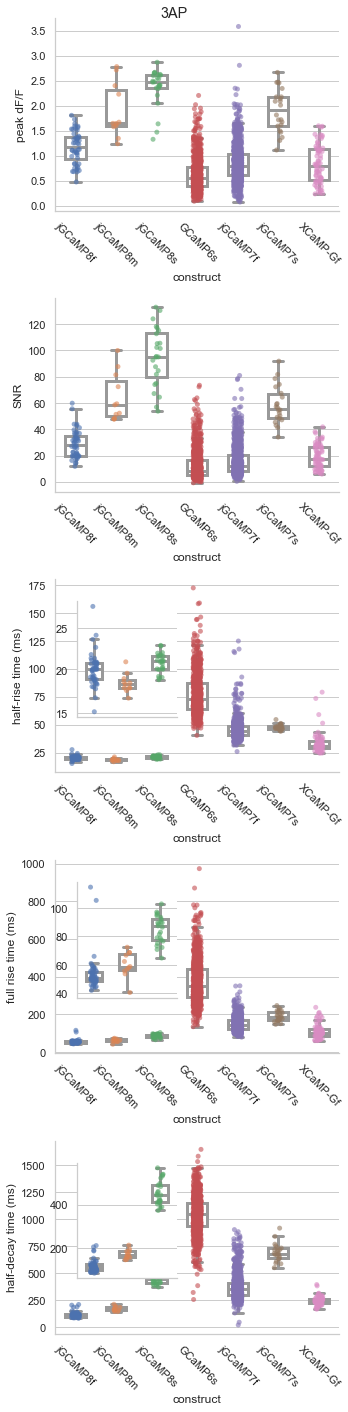

,peak dF/F,SNR,half-rise time (ms),full rise time (ms),half-decay time (ms)
construct,,,,,
GCaMP6f,0.46+/-0.323,6.03+/-8.197,46.59+/-11.998,144.49+/-39.114,303.21+/-62.297
GCaMP6s,0.63+/-0.335,12.87+/-11.502,77.09+/-18.068,373.5+/-116.042,1039.74+/-182.426
XCaMP-G,0.99+/-0.65,26.22+/-16.649,43.68+/-16.593,152.4+/-49.177,318.15+/-55.941
XCaMP-Gf,0.83+/-0.378,19.18+/-9.002,33.48+/-9.499,111.49+/-39.066,245.0+/-41.324
XCaMP-Gf0,0.62+/-0.303,15.38+/-7.572,33.71+/-10.405,129.46+/-43.538,259.34+/-41.907
jGCaMP7b,1.58+/-0.317,65.19+/-14.447,57.83+/-3.407,206.31+/-17.675,520.94+/-26.264
jGCaMP7c,0.94+/-0.306,28.77+/-11.176,51.67+/-5.791,236.03+/-45.103,584.66+/-57.235
jGCaMP7f,0.85+/-0.371,16.23+/-11.758,45.71+/-9.023,149.71+/-36.437,377.77+/-119.842
jGCaMP7s,1.91+/-0.433,58.28+/-14.427,47.73+/-2.407,190.1+/-27.215,694.08+/-83.103


============10AP============


<ipython-input-1-1594c8c4206d>:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()
<ipython-input-1-1594c8c4206d>:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()
<ipython-input-1-1594c8c4206d>:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


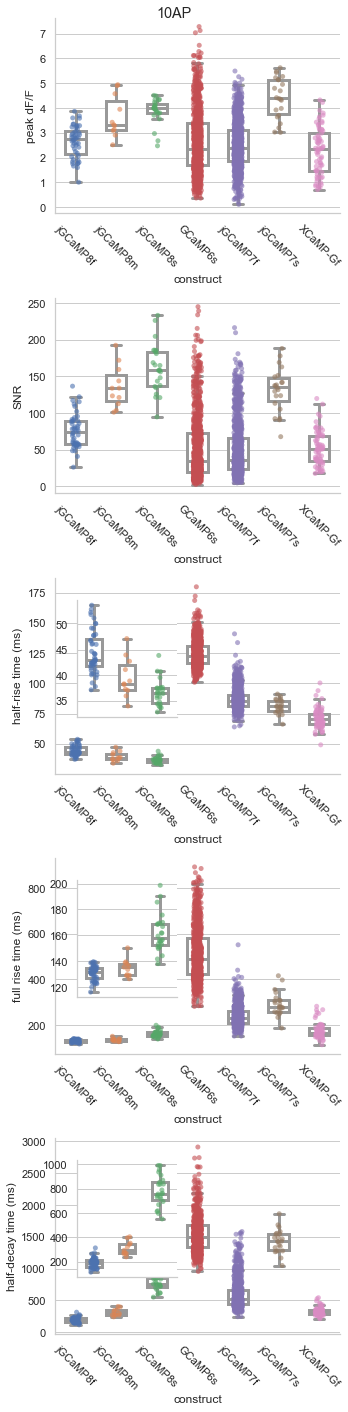

,peak dF/F,SNR,half-rise time (ms),full rise time (ms),half-decay time (ms)
construct,,,,,
GCaMP6f,1.67+/-0.842,21.66+/-19.491,91.67+/-6.82,213.52+/-31.666,372.54+/-79.23
GCaMP6s,2.62+/-1.277,52.59+/-45.58,124.66+/-10.969,512.79+/-115.687,1537.07+/-276.378
XCaMP-G,2.5+/-1.068,67.71+/-26.09,80.4+/-8.191,213.27+/-44.05,432.72+/-78.579
XCaMP-Gf,2.27+/-0.948,52.19+/-22.721,70.99+/-8.282,174.93+/-33.358,326.17+/-65.418
XCaMP-Gf0,1.79+/-0.847,43.51+/-20.836,73.03+/-8.526,184.53+/-57.487,346.76+/-73.783
jGCaMP7b,3.28+/-0.436,136.14+/-20.944,85.39+/-4.272,289.07+/-24.65,971.68+/-101.055
jGCaMP7c,4.3+/-1.376,124.1+/-46.493,106.73+/-6.639,363.74+/-63.631,783.15+/-94.674
jGCaMP7f,2.51+/-0.939,50.34+/-37.564,87.08+/-8.55,239.45+/-42.525,593.85+/-230.96
jGCaMP7s,4.41+/-0.834,131.65+/-29.834,80.98+/-5.875,291.87+/-52.171,1431.88+/-184.014


============160AP============


<ipython-input-1-1594c8c4206d>:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()
<ipython-input-1-1594c8c4206d>:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()
<ipython-input-1-1594c8c4206d>:80: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  f.tight_layout()


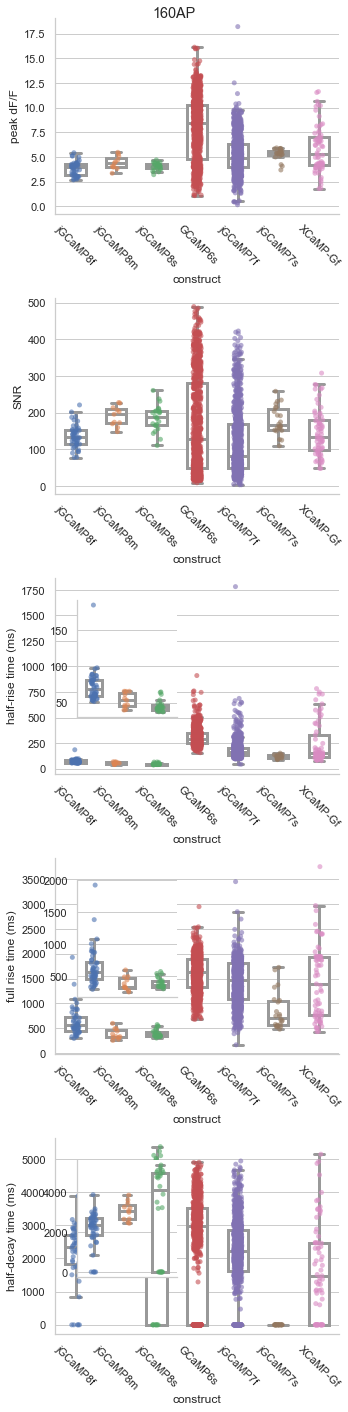

,peak dF/F,SNR,half-rise time (ms),full rise time (ms),half-decay time (ms)
construct,,,,,
GCaMP6f,4.79+/-2.557,74.85+/-73.21,222.7+/-99.385,1341.21+/-525.325,1507.67+/-630.221
GCaMP6s,7.87+/-3.207,167.61+/-130.518,309.94+/-90.769,1601.51+/-368.492,2418.86+/-1575.837
XCaMP-G,5.68+/-1.826,159.21+/-57.813,195.95+/-114.35,1067.77+/-534.188,1506.03+/-1341.016
XCaMP-Gf,5.78+/-2.341,145.31+/-62.371,247.11+/-201.893,1438.49+/-741.893,1699.94+/-1462.779
XCaMP-Gf0,5.54+/-2.919,142.55+/-77.412,276.42+/-171.952,1635.95+/-666.99,1439.8+/-1491.864
jGCaMP7b,3.84+/-0.202,176.42+/-35.453,111.21+/-16.789,846.72+/-389.556,654.64+/-1539.341
jGCaMP7c,19.89+/-6.051,590.8+/-210.751,379.74+/-77.339,1827.18+/-417.814,1897.65+/-1741.024
jGCaMP7f,5.22+/-1.904,117.58+/-90.928,185.79+/-96.65,1438.26+/-431.362,2137.66+/-1110.37
jGCaMP7s,5.29+/-0.595,178.44+/-39.105,115.01+/-16.79,848.14+/-377.192,0.0+/-0.0


In [1]:
'''
plot grand averages, single wells
if no re-processing is needed, do not run previous cell

@todo: save figs
@todo: export csvs for prism

'''
from scipy.io import loadmat
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

hits_label = ['jGCaMP8f', 'jGCaMP8m', 'jGCaMP8s', 'GCaMP6s', 'jGCaMP7f', 'jGCaMP7s', 'XCaMP-Gf']

# magnify the kinetics of the following hits
magnify_hits_label = ['jGCaMP8f', 'jGCaMP8m', 'jGCaMP8s']
all_idx = [0,1,2,3] # all APs to plot
all_idx_str = ['1AP', '3AP', '10AP', '160AP']
subplot_titles = ['peak dF/F', 'SNR', 'half-rise time (ms)', 'full rise time (ms)', 'half-decay time (ms)']

for apidx in all_idx:
    print('============{}============'.format(all_idx_str[apidx]))
    df_loaded = pd.read_pickle('data/grand-avg-data_{}.pkl'.format(apidx))
    df_hits = df_loaded[df_loaded.construct.isin(hits_label)]
    df_magnify_hits = df_loaded[df_loaded.construct.isin(magnify_hits_label)]

    f = plt.figure(figsize=(5,20))
    # ax = sns.violinplot(x="construct", y="half-rise time", data=df_hits, inner=None, scale='width')
    f.suptitle(all_idx_str[apidx])
    sns.set_theme()
    sns.set_style('whitegrid')


    subplot_idx = 1
    for var_to_plot in subplot_titles:
        plt.subplot(5,1,subplot_idx)
        subplot_idx +=1
        ax = sns.boxplot(x="construct", 
                         y=var_to_plot, 
                         data=df_hits, 
                         order = hits_label, 
                         showfliers=False, 
                         color='white',
                         linewidth=3,
                         width=.5)
        ax = sns.stripplot(x="construct",
                           y=var_to_plot, 
                           data=df_hits, 
                           order = hits_label, 
                           size=5,
                          alpha=0.6)
        plt.xticks(rotation=-45)
        
        # need jG8 insets in all 'time'-containing fields
        if 'time' in var_to_plot:
            # magnification inset
            ins_ax = inset_axes(ax, width="35%", height="60%", loc=2, borderpad=2)
            ins_ax = sns.boxplot(x="construct", 
                                y=var_to_plot, 
                                data=df_magnify_hits, 
                                order = magnify_hits_label, 
                                showfliers=False, 
                                color='white',
                                linewidth=3,
                                width=.5)
            ins_ax = sns.stripplot(x="construct",
                                y=var_to_plot, 
                                data=df_magnify_hits, 
                                order = magnify_hits_label, 
                                size=5,
                                alpha=0.6)

            ins_ax.set_xlabel(None)
            ins_ax.set_ylabel(None)
            ins_ax.set_xticklabels('')
        
        f.tight_layout()
        plt.savefig('figs/grand_avg_{}.pdf'.format(all_idx_str[apidx]))
    sns.despine()
    plt.show()
    # compute grand average statistics
    means = (df_loaded.groupby('construct').mean()*100).apply(np.round)/100 # just a way to get a reasonable number of sig figs
    stds = (df_loaded.groupby('construct').std()*1000).apply(np.round)/1000
    
    display(means.astype('str')+'+/-'+stds.astype('str'))
    


In [ ]:
# stats
import scipy.stats as ss
import scikit_posthocs as sp

apidx = 0

vars_to_compare = ['peak dF/F', 'SNR', 'half-rise time (ms)', 'full rise time (ms)', 'half-decay time (ms)']
for var_to_compare in vars_to_compare:
    df_loaded = pd.read_pickle('data/grand-avg-data_{}.pkl'.format(apidx))

    # constructs to use for statistics
    stats_subset = ['jGCaMP8f', 'jGCaMP8m', 'jGCaMP8s', 'XCaMP-G', 'XCaMP-Gf', 'XCaMP-Gf0']
    df_stats_subset = df_loaded[df_loaded['construct'].isin(stats_subset)]

    # list of values to compare
    stats_list = [df_stats_subset[df_stats_subset['construct']==c][var_to_compare].to_list() for c in stats_subset]

    #list_stats_subset = [df]
    print('==========={}==========='.format(var_to_compare))
    [_,p] = ss.kruskal(*stats_list)# ss.kruskal(jg8f, jg8m, jg8s, xcg, xcgf, xcgf0)
    print('Kruskal-Wallice test: p = {}'.format(p))
    # Dunn's post-hoc
    display(sp.posthoc_dunn(df_stats_subset, val_col = var_to_compare, group_col='construct', p_adjust='bonferroni'))

In [ ]:
L = [df_stats_subset[df_stats_subset['construct']=='jGCaMP8f'][var_to_compare]]

In [ ]:
stats_list